# Методы понижения размерности

## Уменьшение признакового пространства

Возможны два подхода:
* отбор признаков - в этом мы уже специалисты
* преобразование признаков - а вот этим будем заниматься сегодня

Метод главных компонент - метод поиска приближённого признакового пространства меньшей размерности, в котором новые признаки являются линейными комбинациями старых

Стараемся сохранить как можно больше информации об исходном пространстве

## PCA

Исходная постановка задачи:

* Есть $m$ $d$-мерных векторов: $x_1, \ldots, x_m$, $x_i \in \mathbb{R}^d$
* Хотим перейти из $d$-мерного пространства в $n$-мерное ($n << d$)
* Хотим потерять как можно меньше информации (возможно, иметь возможность потом восстановиться)
$$
		\arg\min\limits_{W\in \mathbb{R}^{n\times d}, U\in \mathbb{R}^{d\times n}} \sum\limits_{i=1}^m ||x_i - UWx_i||^2_2
$$
* Решение этой задачи и называется методом главных компонент

Теорема о виде решения:

Пусть $x_1, \ldots, x_m$ - векторы из $\mathbb{R}^d$, $A=\sum\limits_{i=1}^mx_ix_i^T$. Пусть $u_1, \ldots, u_n$ - собственные векторы, соответствующие $n$ наибольшим собственным значениям матрицы $A$. Тогда решение задачи PCA - взять матрицу $U$, колонки которой - векторы $u_1,\ldots, u_n$

Не вдаваясь в математические подробности, разберёмся, как это выглядит на практике!

In [1]:
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA

matplotlib.rc('font', size= 22)


sns.set_style("dark")

np.random.seed(0)
data = np.random.multivariate_normal(mean=[3, 4], cov=[[2, -1.9], [-1.9, 3]], size=30)

In [2]:
def draw_points(ax, points, **kwargs):
    ax.set_xlim([-5, 10])
    ax.set_ylim([-5, 10])
    ax.grid()
    return ax.scatter(x=points[:, 0], y=points[:, 1], s=120, **kwargs)
    
def draw_component(ax, i, pca, **kwargs):
    bias = pca.mean_
    kwargs.setdefault('width', 0.1)
    return ax.arrow(*bias, *(pca.components_[i] * pca.explained_variance_[i]), **kwargs)

Сгенерируем какую-нибудь небольшую обучающую выборку и посмотрим на примере, как работает PCA:

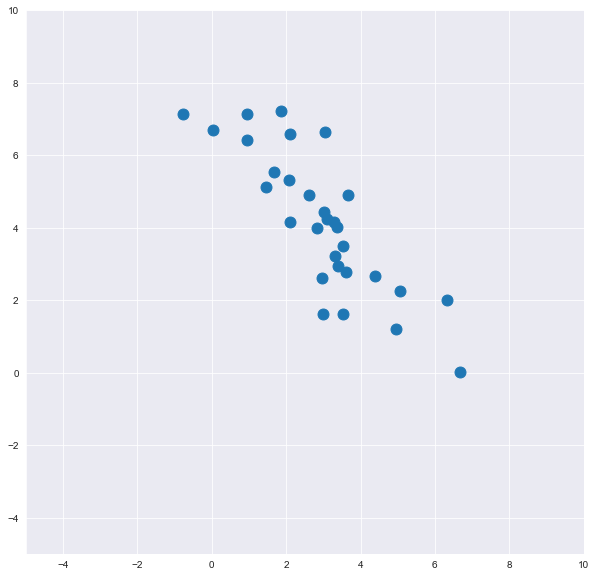

In [3]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
draw_points(ax, data)

In [4]:
pca = PCA(n_components=2).fit(data)

Собственно, главные компоненты:

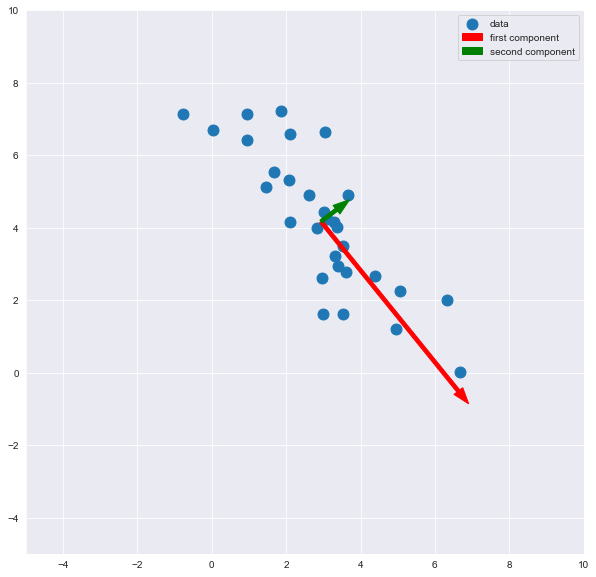

In [5]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.legend([
    draw_points(ax, data),
    draw_component(ax, 0, pca, color='red'),
    draw_component(ax, 1, pca, color='green')
],
[
    'data',
    'first component',
    'second component'
]);

In [6]:
pca = PCA(n_components=1).fit(data)
projected_data = pca.transform(data)

Более наглядная картинка с точки зрения того, что происходит вдоль каждой компоненты:

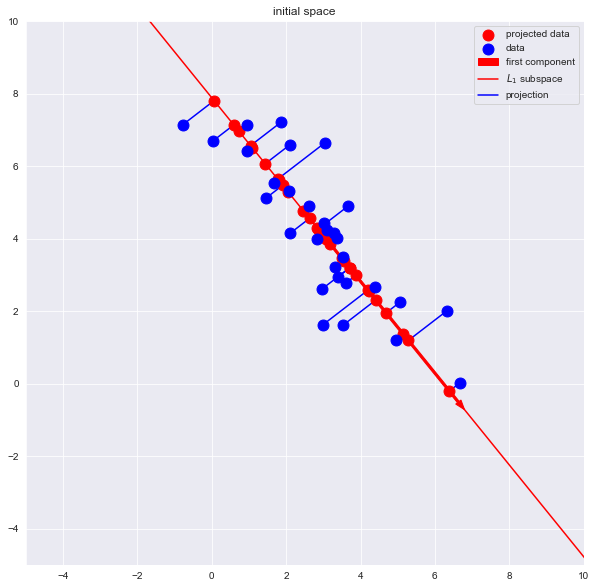

In [7]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))

a_0 = pca.mean_
a_1 = pca.components_[0]

# get points on L_1
projected_points = a_0 + a_1 * (data - a_0).dot(a_1)[:, None]

# draw L_1
p = a_0 + np.array([[-10], [20]]) * a_1
ax.plot(p[:, 0],  p[:, 1], color='red')
L_1 = Line2D([0], [0], color='red')

# draw first principal component
component = draw_component(ax, 0, pca, color='red', width=0.06),
proj = Line2D([0], [0], color='blue')

# draw direction of projection
for pp, p in zip(projected_points, data):
    ax.plot([p[0], pp[0]], [p[1], pp[1]], color='blue')


ax.legend([
    draw_points(ax, projected_points, color="red", zorder=11),
    draw_points(ax, data, color='blue', zorder=11),
    component,
    L_1,
    proj
],
[
    'projected data',
    'data',
    'first component',
    '$L_1$ subspace',
    'projection'
]);
ax.grid()
ax.set_title('initial space');

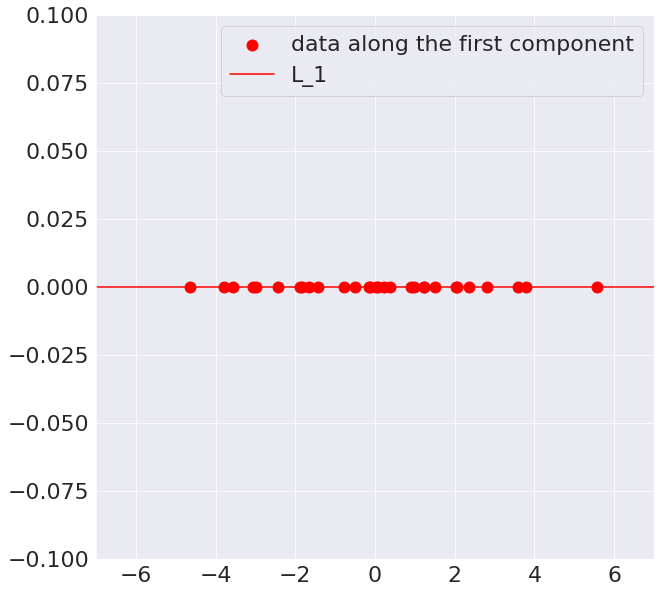

In [9]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot([-7, 7], [0, 0], color='red')
ax.legend([
    draw_points(ax, np.hstack([projected_data, np.zeros_like(projected_data)]), color='red'),
    Line2D([0], [0], color='red')
],
[
    'data along the first component',
    'L_1'
]);
ax.set_xlim([-7, 7])
ax.set_ylim([-0.1, 0.1]);

Но не стоит думать, что всегда всё так хорошо. Надо помнить, что PCA - это линейное преобразование. Поэтому с некоторыми выборками работает плохо:

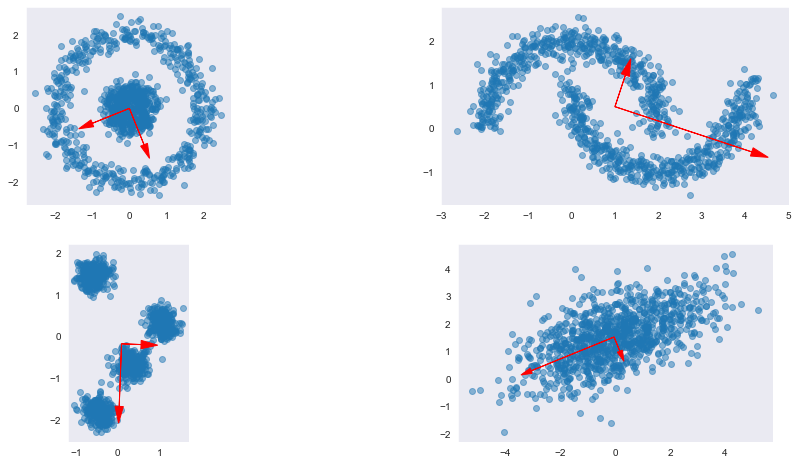

In [8]:
from sklearn.datasets import make_circles, make_moons, make_blobs

def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)
    
    dec = PCA()
    dec.fit(dataset)
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]):
        component = dec.components_[comp_ind, :]
        var = dec.explained_variance_[comp_ind]
        start, end = dec.mean_, component * var
        ax.arrow(start[0], start[1], end[0], end[1],
                 head_width=0.2, head_length=0.4, fc='r', ec='r')
    
    ax.set_aspect('equal', adjustable='box')

np.random.seed(54242)
data_synth_bad = [
    make_circles(n_samples=1000, factor=0.2, noise=0.1)[0]*2,
    make_moons(n_samples=1000, noise=0.1)[0]*2,
    make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5,
    np.random.multivariate_normal(
        mean=[0, 1.5], 
        cov=[[3, 1], 
             [1, 1]],
        size=1000),
]


plt.figure(figsize=(16,8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

Но нам не привыкать, что там где не справляются линейные методы, справится введение ядер!

Вспоминаем: речь идёт о матрице ковариации признаков $X^TX$, то есть вычисляются скалярные произведения. А там, где есть скалярные произведения, можно попробовать их заменить на ядра:

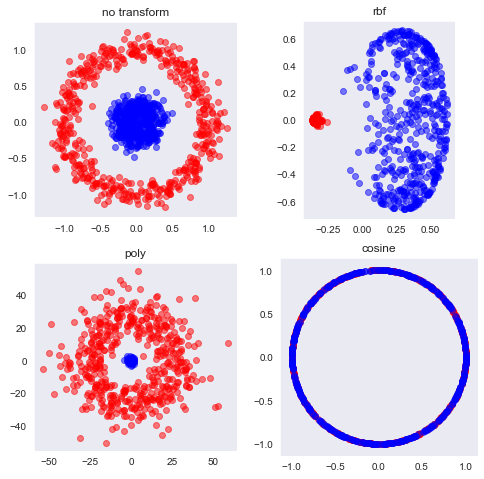

In [9]:
from sklearn.decomposition import KernelPCA


def KPCA_show(X, y):
    reds = y == 0
    blues = y == 1
    
    plt.figure(figsize=(8, 8))
    rows, cols = 2, 2
    plt.subplot(rows, cols, 1)
    plt.scatter(X[reds, 0], X[reds, 1], alpha=0.5, c='r')
    plt.scatter(X[blues, 0], X[blues, 1], alpha=0.5, c='b')
    plt.title('no transform')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    
    kernels_params = [
        dict(kernel='rbf', gamma=10),
        dict(kernel='poly', gamma=10),
        dict(kernel='cosine', gamma=10),
    ]
    
    for i, p in enumerate(kernels_params):
        dec = KernelPCA(**p)
        X_transformed = dec.fit_transform(X)
        
        plt.subplot(rows, cols, i + 2)
        plt.scatter(X_transformed[reds, 0], X_transformed[reds, 1], alpha=0.5, c='r')
        plt.scatter(X_transformed[blues, 0], X_transformed[blues, 1], alpha=0.5, c='b')
        plt.title(p['kernel'])
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        
np.random.seed(54242)
KPCA_show(*make_circles(n_samples=1000, factor=0.2, noise=0.1))

### Лица людей

Ниже представлены элементы датасета с лицами людей. Последнее - ''среднее'' лицо:

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/Jeniamakarchik/scikit_learn_data


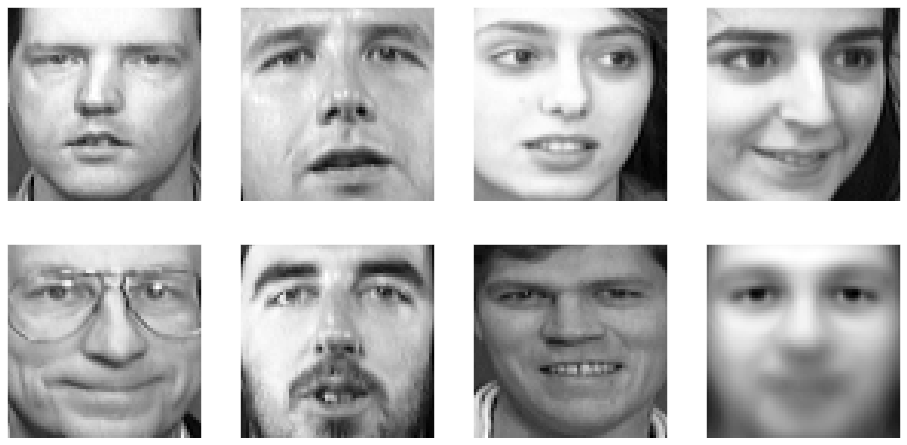

In [10]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True, random_state=432542)
faces_images = faces.data
faces_ids = faces.target
image_shape = (64, 64)
    
mean_face = faces_images.mean(axis=0)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples - 1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(faces_images[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
plt.subplot(rows, cols, n_samples)
plt.imshow(mean_face.reshape(image_shape), interpolation='none',
           cmap='gray')
plt.xticks(())
_ = plt.yticks(())

Давайте визуализируем те самые главные компоненты!

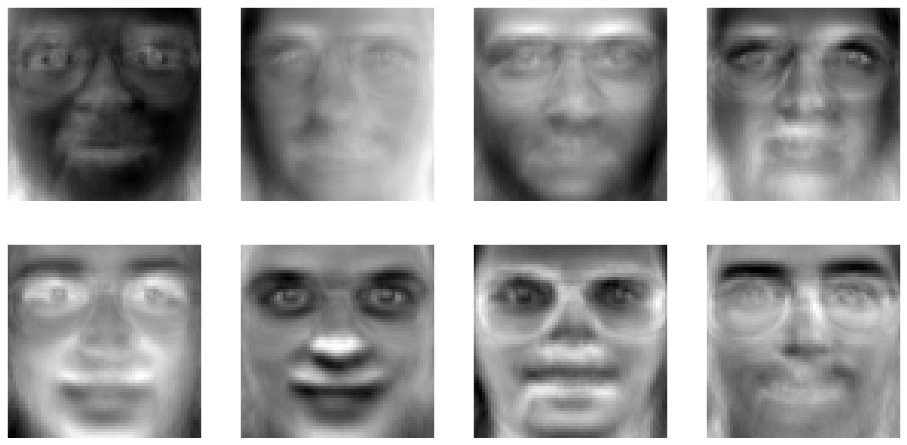

In [11]:
red = PCA()
faces_images -= mean_face
red.fit(faces_images)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(red.components_[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())

Выглядит, конечно, прикольно, но может быть ещё на что-нибудь сгодится?

**Более лучшие признаки**

Да, я знаю, что так говорить неграмотно. Да, если перебирать по бОльшей сетке, то результат будет ещё лучше:

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

gscv_rf = GridSearchCV(RandomForestClassifier(),
                       {'n_estimators': [100], 'max_depth': [2]},
                       cv=5)

In [20]:
gscv_rf.fit(faces_images, faces_ids)
print(gscv_rf.best_score_)

0.5175


In [21]:
gscv_rf.fit(red.transform(faces_images)[:,:100], faces_ids)
print(gscv_rf.best_score_)

0.66


**Сжатие данных**

Если есть главные компоненты, то есть и неглавные. И если их выбросить, то для картинки измениться ничего особо не должно:

In [13]:
base_size = image_shape[0] * image_shape[1]

def compress_and_show(compress_ratio):
    red = PCA(n_components=int(base_size * compress_ratio))
    red.fit(faces_images)

    faces_compressed = red.transform(faces_images)
    faces_restored = red.inverse_transform(faces_compressed) + mean_face

    plt.figure(figsize=(16, 8))
    rows, cols = 2, 4
    n_samples = rows * cols
    for i in range(n_samples):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(faces_restored[i, :].reshape(image_shape), interpolation='none',
                   cmap='gray')
        plt.xticks(())
        plt.yticks(())

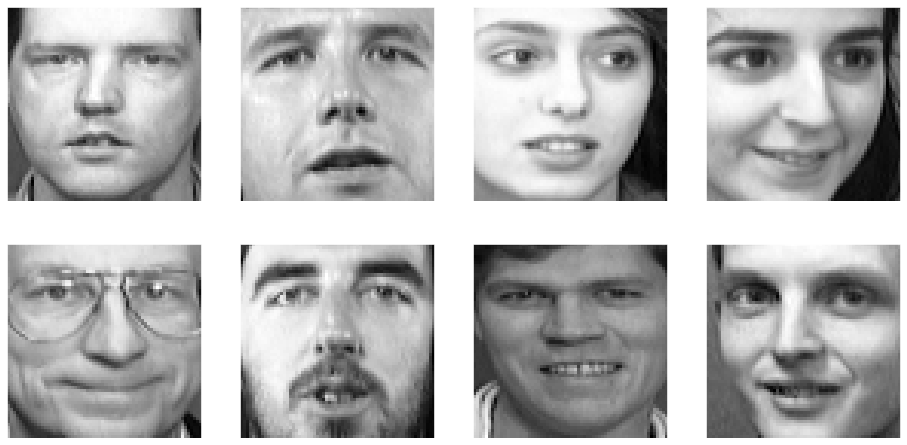

In [14]:
compress_and_show(0.09)

**Задание 1. (1 балл)**. Так уж выходит, что люди часто любят преобразовывать длинные векторы (в том числе и картинки) в латентные пространства более низкой размерности. Обычно получается, что эти латентные пространства обладают всякими интересными свойствами. Например, в них можно брать линейные комбинации векторов, соответствующих объектам, декодировать и получать объекты похожего толка. Это вам и предлагается сделать!

А именно, напишите функцию, которая будет работать с выборкой лиц. Пускай она принимает на вход два индекса - индексы изображений-лиц из выборки. А на выходе визуализирует ''путешествие'' между этими лицами в латентном пространстве.

Более формально, если у вас есть два изображения $I_1$ и $I_2$, а также методы кодирования $Encode(I)$ и декодирования $Decode(I)$ этих изображений в вектор небольшой размерности (здесь это PCA), можно получить последовательность изображений:
$$
I_j = Decode(\alpha_j Encode(I_1) + (1 -\alpha_j) Encode(I_2)),\ \alpha_j = \frac{j}{k}, j=0,\ldots,k
$$

In [67]:
def path_btw_images(img_1, img_2, n_iter = 11, compress_ratio=0.09, image_shape=(64, 64)):
    plt.figure(figsize=(20, 15))
    
    for i in range(n_iter+1):
        alpha = i/n_iter
        
        base_shape = image_shape[0]*image_shape[1]
        
        img = alpha*img_1 + (1 - alpha)*img_2
        img = img.reshape(-1, 1)
        
        red = PCA(n_components=1)
        red.fit(img)
        
        img_compressed = red.transform(img)
        img_restored = red.inverse_transform(img_compressed)
        
        plt.subplot((n_iter+1)//4, 4, i + 1)
        plt.imshow(img_restored.reshape(image_shape), interpolation='none',cmap='gray')
        plt.xticks(())
        plt.yticks(())

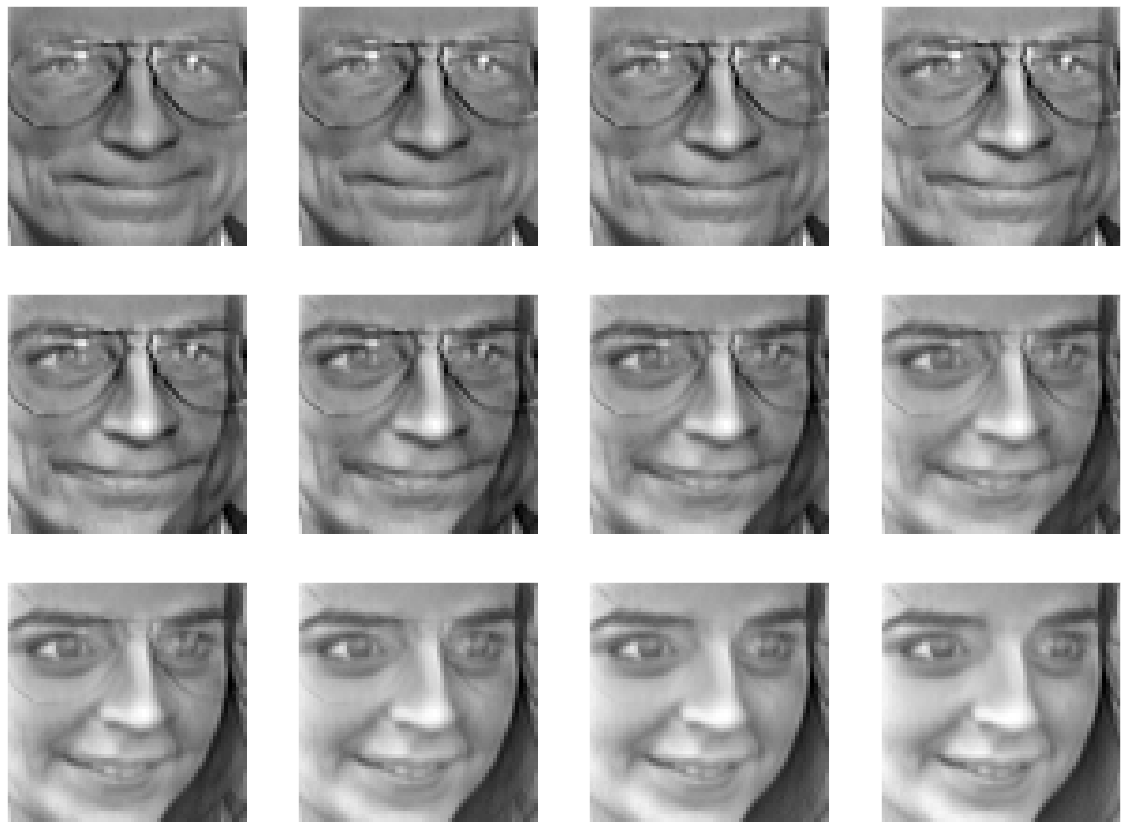

In [142]:
path_btw_images(faces_images[3, :], faces_images[4, :])

### Финальная ремарка про геометрическую интерпретацию

![](https://i.ibb.co/ZdYXLBf/Screenshot-from-2020-03-30-09-01-46.png)

По теореме Пифагора, суммарное расстояние от точек выборки до центра равно суммарной ошибке проекции плюс дисперсии. И эта величина константна. Значит чем больше дисперсия - тем меньше ошибка проекции.

### Гифка для привлечения внимания к теме

![ChessUrl](https://i.stack.imgur.com/Q7HIP.gif)

### Полезные ссылки

* https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca - про PCA и его отношение с SVD
* https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579 - прекрасный комментарий-история про PCA (начинается со слов "Imagine a big family dinner, where everybody starts asking you about PCA"), гифка оттуда

## t-SNE

В отличии от PCA, задача t-SNE - это сохранить пространственную структуру данных. Например, это может быть полезно для визуализации.

Идея метода заключается в следующем:

* превратим расстояния между объектами в исходном пространстве в вероятности: 

$$p_{j|i} = \frac{\exp{(-d(\boldsymbol{x}_i, \boldsymbol{x}_j) / (2 \sigma_i^2)})}{\sum_{i \neq k} \exp{(-d(\boldsymbol{x}_i, \boldsymbol{x}_k) / (2 \sigma_i^2)})}, \quad p_{i|i} = 0,$$

* посчитаем некоторую новую метрику

$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}.$$

* здесь $\sigma_i$ определяются автоматически для каждого из объектов так, чтобы в областях с высокой плотностью была дисперсия меньше



* теперь определим вероятностное расстояние между точками в новом пространстве:

$$q_{ij} = \frac{(1 + ||\boldsymbol{y}_i - \boldsymbol{y}_j)||^2)^{-1}}{\sum_{k \neq l} (1 + ||\boldsymbol{y}_k - \boldsymbol{y}_l)||^2)^{-1}},$$

* и будем минимизировать разницу между матрицей расстояний в исходном пространстве и в новом:

$$KL(P||Q) = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}$$

* делать это будем с помощью градиентного спуска

* за подробностями - в оригинальную статью

### Гифка для привлечения внимания к теме

![ChessUrl](https://d3ansictanv2wj.cloudfront.net/images/animation-94a2c1ff.gif)

**Задание 2 (2 балла)**. А давайте мы сами тоже получим такую красивую картинку :)
* загрузите датасет с цифрами из sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)
* используйте t-SNE (https://scikit-learn.org/0.20/modules/generated/sklearn.manifold.TSNE.html) на 64-мерных векторах фичей, чтобы сжать их до размерности 2
* визуализируйте новые объекты на плоскости, причём разные классы отобразите разными цветами

In [73]:
from sklearn.datasets import load_digits

data = load_digits()['data']
data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [75]:
data.shape

(1797, 64)

In [107]:
from sklearn.manifold import TSNE
Y = TSNE(n_components=2, perplexity=30, n_iter=1500).fit_transform(data)
Y = pd.DataFrame(Y, columns=['dim1', 'dim2'])
Y.shape

(1797, 2)

In [108]:
labels = load_digits()['target']
Y['labels'] = labels
Y.shape

(1797, 3)

/usr/local/lib/python3.7/site-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


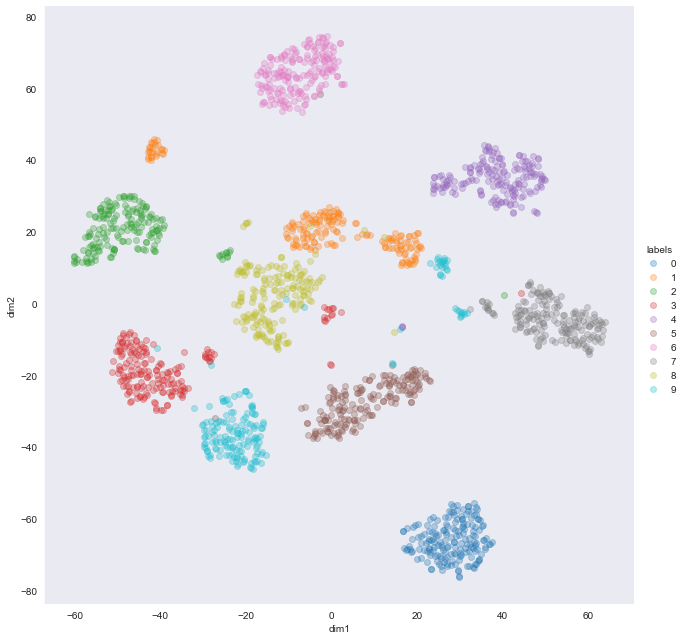

In [109]:
import pandas as pd
import seaborn as sns

sns.lmplot(x='dim1',
           y='dim2',
           data=Y,
          fit_reg=False,
          legend=True,
          size=9,
          hue='labels',
          scatter_kws={'alpha': 0.3})

### Полезные ссылки

* http://jmlr.csail.mit.edu/papers/volume9/vandermaaten08a/vandermaaten08a.pdf - оригинальная статья про t-SNE
* https://lvdmaaten.github.io/tsne/ - гитхаб автора с примерами применения t-SNE для разных данных (и не только)
* https://distill.pub/2016/misread-tsne/ - очень красивая визуализация на тему t-SNE и подбора параметров
* https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm?imm_mid=0d3385&cmp=em-data-na-na-newsltr_20150610 - объяснение t-SNE с картинками (гифка оттуда)

## Другие алгоритмы понижения размерности

### Truncated SVD

* для того, чтобы вся теория в PCA сходилась и можно было применять метод, данные должны быть нормированы, т.е. иметь нулевое среднее (а лучше и единичную дисперсию)
* нормировать, например, разреженные матрицы очень неудобно: они перестают быть разреженными
* Truncated SVD позволяет добиваться того же самого, но без нормировки

### IncrementalPCA

* когда речь заходит об огромном количестве данных, как-то пользоваться алгоритмами примерно кубической сложности (каким является PCA) не очень удобно
* но существуют методы, которые умеют принимать выборку небольшими кусочками и их сложность зависит не от объёма всей выборки, а от объёма кусочка
* таким алгоритмом, например, является IncrementalIPCA

https://www.kaggle.com/shivamb/dataset-decomposition-techniques - про разные схемы понижения размерности на примере одного kaggle-соревнования

# Многоклассовая классификация

Иногда в жизни нужно решать задачу многоклассовой классификации:
* классификация цифр
* классификация лиц
* ирисы

Но есть и **мульти**классовая классификация:
* многоклассовая - это предсказать одну метку для каждого объекта, но всего вариантов тьма
* мультиклассовая - это предсказать много меток для каждого объекта, а вариантов всё равно тьма

Значит придётся и нам учиться!

Как правило, есть 3 варианта:
* взять бинарный классификатор и сделать One vs. One
* взять бинарный классификатор и сделать One vs. Rest
* обобщить методы бинарной классификации на бОльшие размерности

Разберёмся с последним:
* kNN плевать на то, сколько классов
* решающим деревьям тоже
* а вот с линейными методами чуть сложнее...

Двухклассовая классификация:
* $$
			a(x) = sign\langle w, x\rangle
$$
* $$
			a(x) = sign(\langle w, x\rangle - \langle -w, x\rangle)
$$
* $$
			a(x) = \arg\max\limits_{k\in \{-1, +1\}} \langle w_k, x\rangle 
$$
* $$
			w_{+1} = w,\ w_{-1} = -w
$$

Многоклассовая классификация:\pause
* $$
			a(x) =  \arg\max\limits_{k\in \{1, \ldots, K\}} \langle w_k, x\rangle 
$$

## One vs. One

![](https://i.imgur.com/NreKSdj.png)

## One vs. Rest

![](https://i.imgur.com/zZ8Ey32.png)

## А теперь на практике!

Сгенерируем небольшую выборку данных для трёхклассовой классификации:

In [112]:
from sklearn.datasets import make_classification

In [113]:
X, y = make_classification(n_features=2, n_classes=3, n_informative=2, n_redundant=0, n_repeated=0, n_clusters_per_class=1)

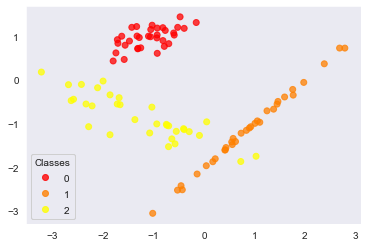

In [139]:
fig, ax = plt.subplots()
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', alpha=0.75)
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend)
plt.show()

**Задание 3 (1 балл).** Давайте сравним методы (One vs. One) vs. (One vs. Rest). Используя логистическую регрессию и соответствующие методы из sklearn (https://scikit-learn.org/0.20/modules/generated/sklearn.multiclass.OneVsOneClassifier.html#sklearn.multiclass.OneVsOneClassifier и https://scikit-learn.org/0.20/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier), численно, нарисовав confusion matrix (https://scikit-learn.org/0.20/modules/generated/sklearn.metrics.confusion_matrix.html) для того, чтобы определить, какие классы чаще всего смешиваются в каждом из методов.

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

In [131]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[34  0  0]
 [ 0 32  1]
 [ 0  4 29]]


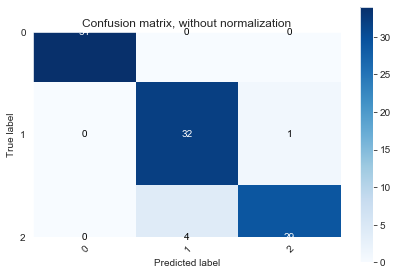

In [132]:
clf_1vs1 = OneVsOneClassifier(LogisticRegression(solver='liblinear'))
clf_1vs1.fit(X, y)
y_pred_1vs1 = clf_1vs1.predict(X)

plot_confusion_matrix(y, y_pred_1vs1, classes=[0, 1, 2])
plt.show()

Confusion matrix, without normalization
[[34  0  0]
 [ 0 29  4]
 [ 0  4 29]]


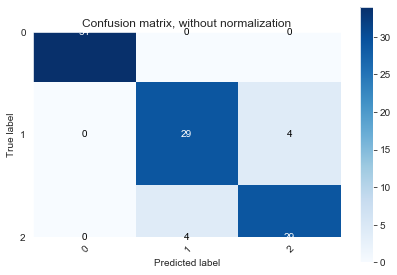

In [133]:
clf_1vsR = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
clf_1vsR.fit(X, y)
y_pred_1vsR = clf_1vsR.predict(X)

plot_confusion_matrix(y, y_pred_1vsR, classes=[0, 1, 2])
plt.show()

Из обеих конфьюжн матриц видно, что 0 класс у нас хорошо отделим от остальных объектов. Это подтверждает и график, на котором объекты класса 0 - красные. 

Оба метода путают желтые объекты с оранжевыми. По графику видно, что это желтые объекты, которые лежат справа от оранжевого кластера.

Метод один против всех путает оранжевые с желтыми. Это может быть вызвано тем, что сложно отделить желтые и красные + оранжевые. 

## Прежде, чем вы приступите

Часто можно придумать разные эвристики про взаимоотношения между классами.

![](https://i.imgur.com/lVNUxTE.png)